In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons
import stretched_echelle_widget as sew
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib notebook

# import stuff to plot

In [4]:
import pandas as pd 
highmass_rc = pd.read_csv('../datatables/highmass_rc_werr.csv')
highmass_rc_newvals = pd.read_csv('../datatables/highmass_rc_newvals.csv')
adopted_masses = pd.read_csv('../datatables/adopted_masses.csv')

In [5]:
def read_star_sample(star_name,suppress_output=True,unpack=False):
#     delta_nu,nu_max,mass,lc,ps
    delta_nu = highmass_rc_newvals['pysyd_dnu'][highmass_rc_newvals['KIC']==float(star_name[4:])].values[0]
    nu_max = highmass_rc_newvals['pysyd_numax'][highmass_rc_newvals['KIC']==float(star_name[4:])].values[0]
    mass = adopted_masses['corr_mass'][adopted_masses['KIC']==float(star_name[4:])].values[0]
    if suppress_output == False:
        print(star_name)
#         print('Using new values')
        print('delta_nu =',delta_nu)
        print('nu_max =',nu_max)
        print('Adopted mass =',mass)
    
    lightcurve = pd.read_csv('../data/hpfiltered_LCs/KIC'+star_name[4:]+'_LC.csv')
    powerspec = pd.read_csv('../data/hpfiltered_LCs/KIC'+star_name[4:]+'_PS.csv')
    if unpack == True:
        if suppress_output == False:
            print('unpacking data frames')
        time = np.asarray(lightcurve['time'])
        flux = np.asarray(lightcurve['flux'])
        freq = np.asarray(powerspec['freq'])
        power = np.asarray(powerspec['power'])
        amp = np.asarray(powerspec['amp'])
        return delta_nu,nu_max,mass,time,flux,freq,power,amp
    else:
        if suppress_output == False:
            print('returning dataframes')
        return delta_nu,nu_max,mass,lightcurve,powerspec

# running the widget

In [121]:
delta_nu,nu_max,mass,lightcurve,powerspec = read_star_sample('KIC 10163776',suppress_output=False)
# delta_nu,nu_max,mass,time,flux,freq,power,amp = read_star('KIC 3758458',unpack=True,suppress_output=False)

freq = powerspec['freq']
power = powerspec['power']

smooth_percent = 0.02
freq_res = np.median(np.diff(freq))
smoothed_power = convolve(power, Box1DKernel((delta_nu*smooth_percent)/freq_res))

KIC 10163776
delta_nu = 6.166957297
nu_max = 74.76656675
Adopted mass = 2.7651068235385714
returning dataframes


<IPython.core.display.Javascript object>


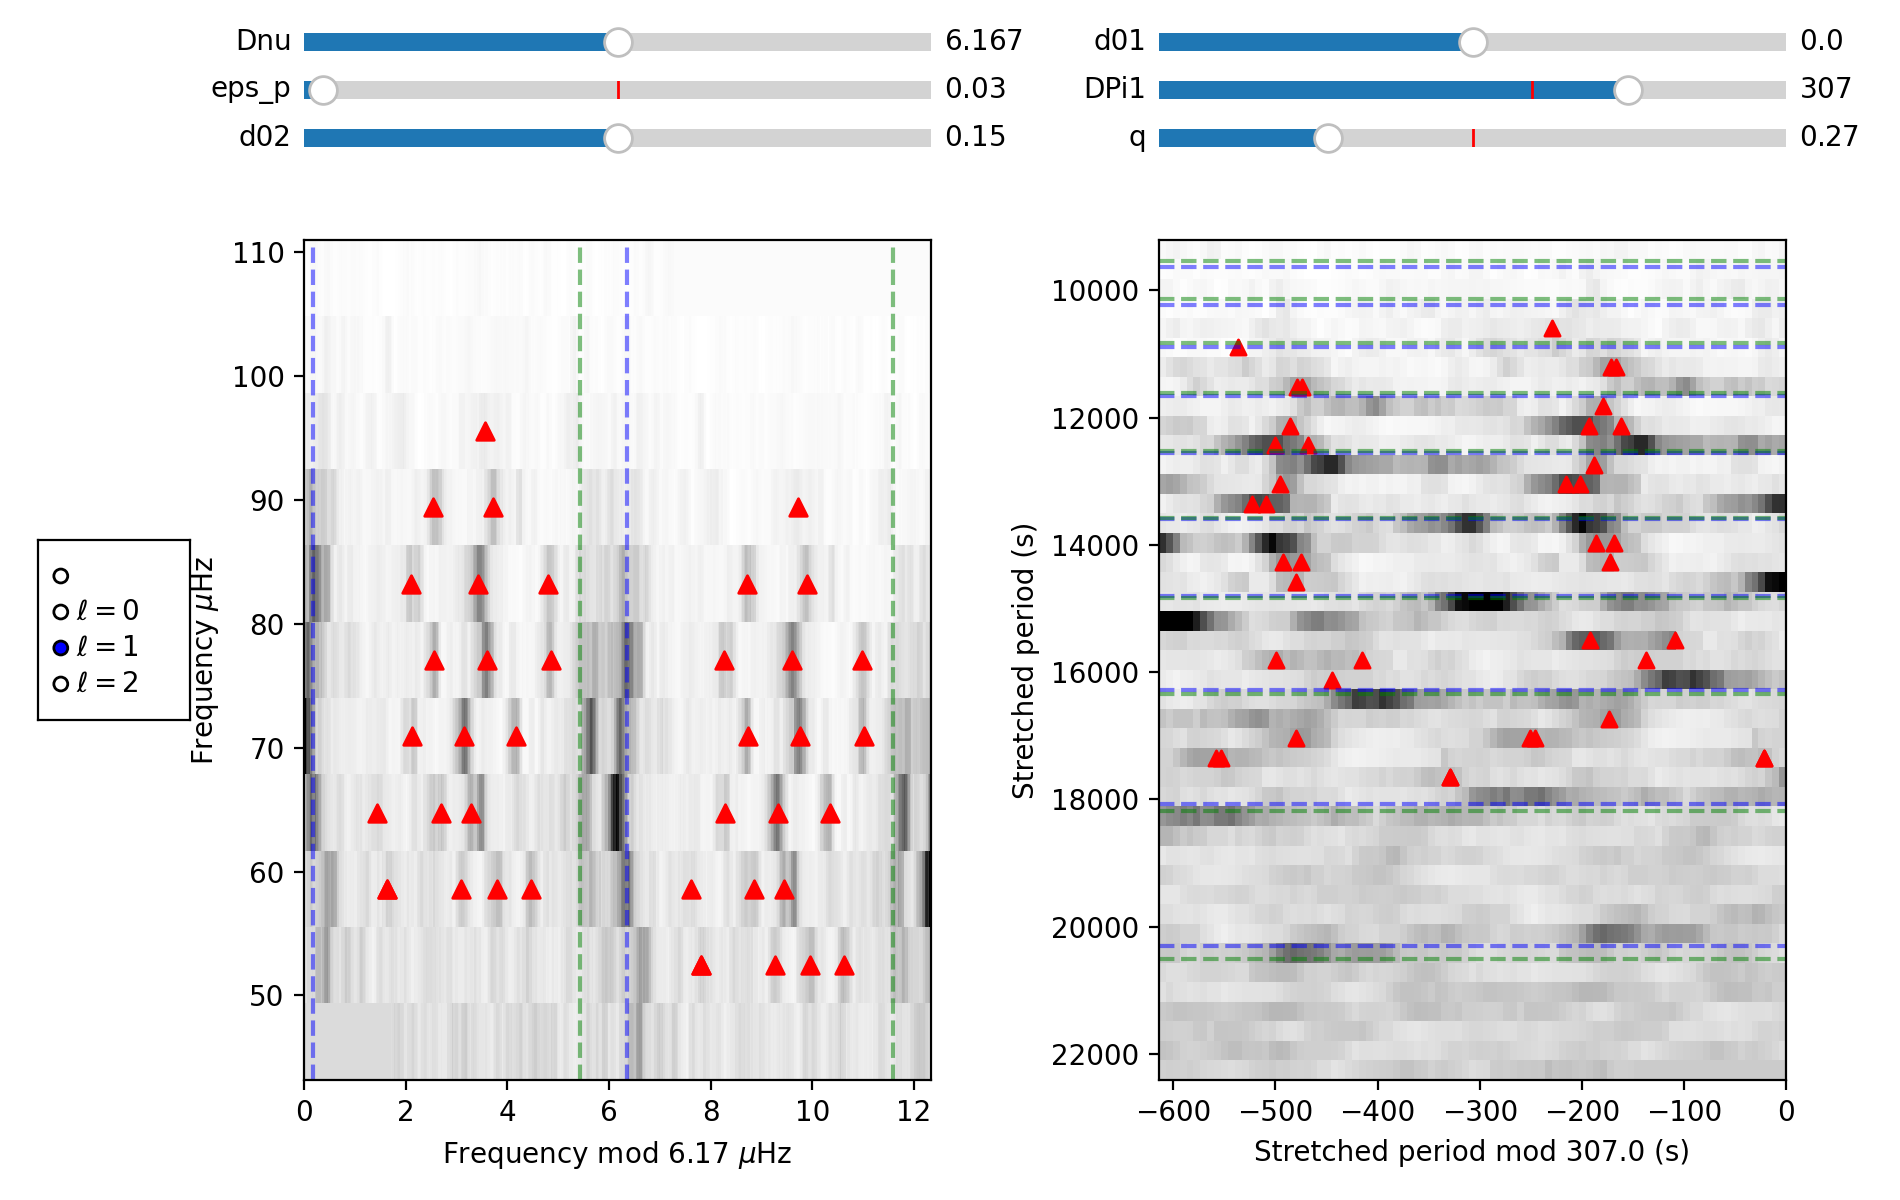

In [122]:
# resample spectrum to have 5000 pixels
# nu = np.linspace(nu_max-5*delta_nu, nu_max+5*delta_nu, 5000)
nu = np.linspace(0.5*nu_max, 1.5*nu_max, 5000)
ps = np.interp(nu, freq, smoothed_power)

# initiate a star object
star = sew.Star(nu, ps, nu_max, delta_nu,fmin=0.6*nu_max, fmax=1.5*nu_max)

# interactive echelles
star.plot_freq_echelle(snapping=True)#,plot_l1_line=True)
# plt.show()

In [8]:
star.f_labels

{0: [], 1: [], 2: []}

# Extra stuff with the output

In [9]:
from scipy.optimize import curve_fit
from scipy.optimize import minimize,basinhopping

In [10]:
def lorentzian(x, amplitude, center, width):
    return (amplitude*width**2/((x-center)**2+width**2))

def peakbag(l,freq_list,freq,power,dnu):
    #want to fit a lorentzian to the region around the clicked peak
    for f in freq_list:
        # probably want to mask around the peak itself
        power_region = power[(f-(dnu*0.07) < freq) & (freq < f+(dnu*0.07))]
        freq_region = freq[(f-(dnu*0.07) < freq) & (freq < f+(dnu*0.07))]
        
        popt, pcov = curve_fit(lorentzian, freq_region, power_region,
                               p0=[max(power_region), f, 0.1])#,
#                               bounds=([0, 0, 0.05], np.inf))
        perr = np.sqrt(np.diag(pcov))
    
        def minus_log_likelihood(theta, freq, power):
            amp, cen, wid, bg = theta
            model = lorentzian(freq,amp,cen,wid) + bg
            return np.sum(np.log(model) + power/model)
        bnds = ((0, None), None, None, None)
#         res = minimize(minus_log_likelihood, [max(power_region), f, 0.1, 1], 
#                        args=(freq_region,power_region), bounds=bnds)
        kwargs = dict({'args':(freq_region,power_region),'method':'BFGS','bounds':bnds})
        res = basinhopping(minus_log_likelihood, [max(power_region), f, 0.1, 1], 
                       minimizer_kwargs=kwargs) # note that BFGS doesn't take bounds so this will have to change
        err = np.sqrt(np.diag(res.lowest_optimization_result.hess_inv))
    
        print('------- CURVE FIT VALUES --------')
        print('Amplitude:',np.round(popt[0],2),'+/-',np.round(perr[0],2))
        print('Center:',np.round(popt[1],2),'+/-',np.round(perr[1],2))
        print('Width:',np.round(popt[2],4),'+/-',np.round(perr[2],4))
        
        print('------- MINIMIZE VALUES ---------')
        print('Amplitude:',np.round(res.x[0],2),'+/-',np.round(err[0],2))
        print('Center:',np.round(res.x[1],2),'+/-',np.round(err[1],2))
        print('Width:',np.round(res.x[2],4),'+/-',np.round(err[2],4))
        print('BG:',np.round(res.x[3],1),'+/-',np.round(err[3],2))
        
#         print(res.lowest_optimization_result.hess_inv)
        
        fig = plt.figure(figsize=(4,2))
        plt.plot(freq_region,power_region,label='data')
        plt.plot(freq_region,lorentzian(freq_region,*popt),
                 linestyle='--',label='curve fit')
        plt.plot(freq_region,lorentzian(freq_region,*res.x[:-1]),
                 linestyle='--',label='minimize fit')
        plt.legend()
        plt.xlabel(r'Frequency ($\mu$Hz)')
        plt.ylabel('Power')
        plt.show()
        
def estimate_dpi(freq_list,numax,dnu):
    # a very back of the envelope estimate
#     freq_list = np.sort(freq_list)
    df = np.diff(freq_list)
    # only take the frequencies next to each other
    df = df[df < dnu*0.5]
    dpi = df/(numax**2) * 1e6
    print('All Dpis:',dpi)
    print('Average Dpi:',np.average(dpi))

In [11]:
estimate_dpi(star.f_labels[1],star.numax,star.Dnu)

All Dpis: []
Average Dpi: nan


In [12]:
# peakbag(1,star.f_labels[1],freq,power,star.Dnu)

# Regular period echelle (with freq list)

In [13]:
def period_echelle(freq_list,numax,dnu,dPi=0):
#     nu_max   = hist.nu_max.values[0]
#     Delta_nu = hist.delta_nu.values[0]
#     Delta_P_default = hist.delta_Pg.values[0] # seconds
#     if Delta_P == 0:
#         Delta_P = Delta_P_default
#     Delta_P = 300
#     print(Delta_P)
    
#     freq = freq[freq['Re(freq)'] < 5/3*numax]
#     dipole = freq[np.logical_and(freq.l == 1, freq.n_p > 2)]
#     period = 1/(dipole['Re(freq)']*1e-6)
    period_list = 1/(np.asarray(freq_list)*1e-6)
#     print(period)
    
#     plt.scatter(dipole['Re(freq)'] % Delta_P, dipole['Re(freq)'], 
#                 marker='.', facecolor='k', edgecolor='k',linewidth=0.5)
    plt.figure(figsize=(6,10))
    plt.scatter(period_list % dPi, freq_list, 
                marker='.', facecolor='k', edgecolor='k',linewidth=0.5)
    plt.plot(period_list % dPi, freq_list, linewidth=0.5)
    
#     colors = ('black', 'red', 'blue', 'purple')
#     for ell in np.unique(freq.l.values):
#         nus = freq[freq.l == ell]
#         plt.scatter(nus['Re(freq)'] % Dnu,
#                  nus['Re(freq)'], marker='.', 
#                 facecolor=colors[ell], edgecolor='k',linewidth=0.5,
#                     alpha=1, s=nus['E_p']*150, 
#                  label=str(ell))
#         plt.plot(nus['Re(freq)'] % Dnu,
#                  nus['Re(freq)'], '.', 
#                  mfc=colors[ell], mec='white', alpha=0.85,
#                  mew=1, markersize=nus['E_p'], 
#                  label=str(ell))
    
#     plt.legend(loc='lower right')
    
    plt.axvline(dPi, ls='--', c='darkgray', zorder=-99)
    plt.axhline(numax, ls='--', c='darkgray', zorder=-99)
    
#     plt.ylim([0, nu_max*5/3*1.2])
    plt.xlim([0, dPi])
    
    plt.ylabel(r'frequency $\nu/\mu\rm{Hz}$')
    plt.xlabel(r'P $\rm{mod}\; \Delta P/s$ '+str(dPi))
    plt.title('Period Echelle Diagram', size=24)
    plt.show()

<IPython.core.display.Javascript object>


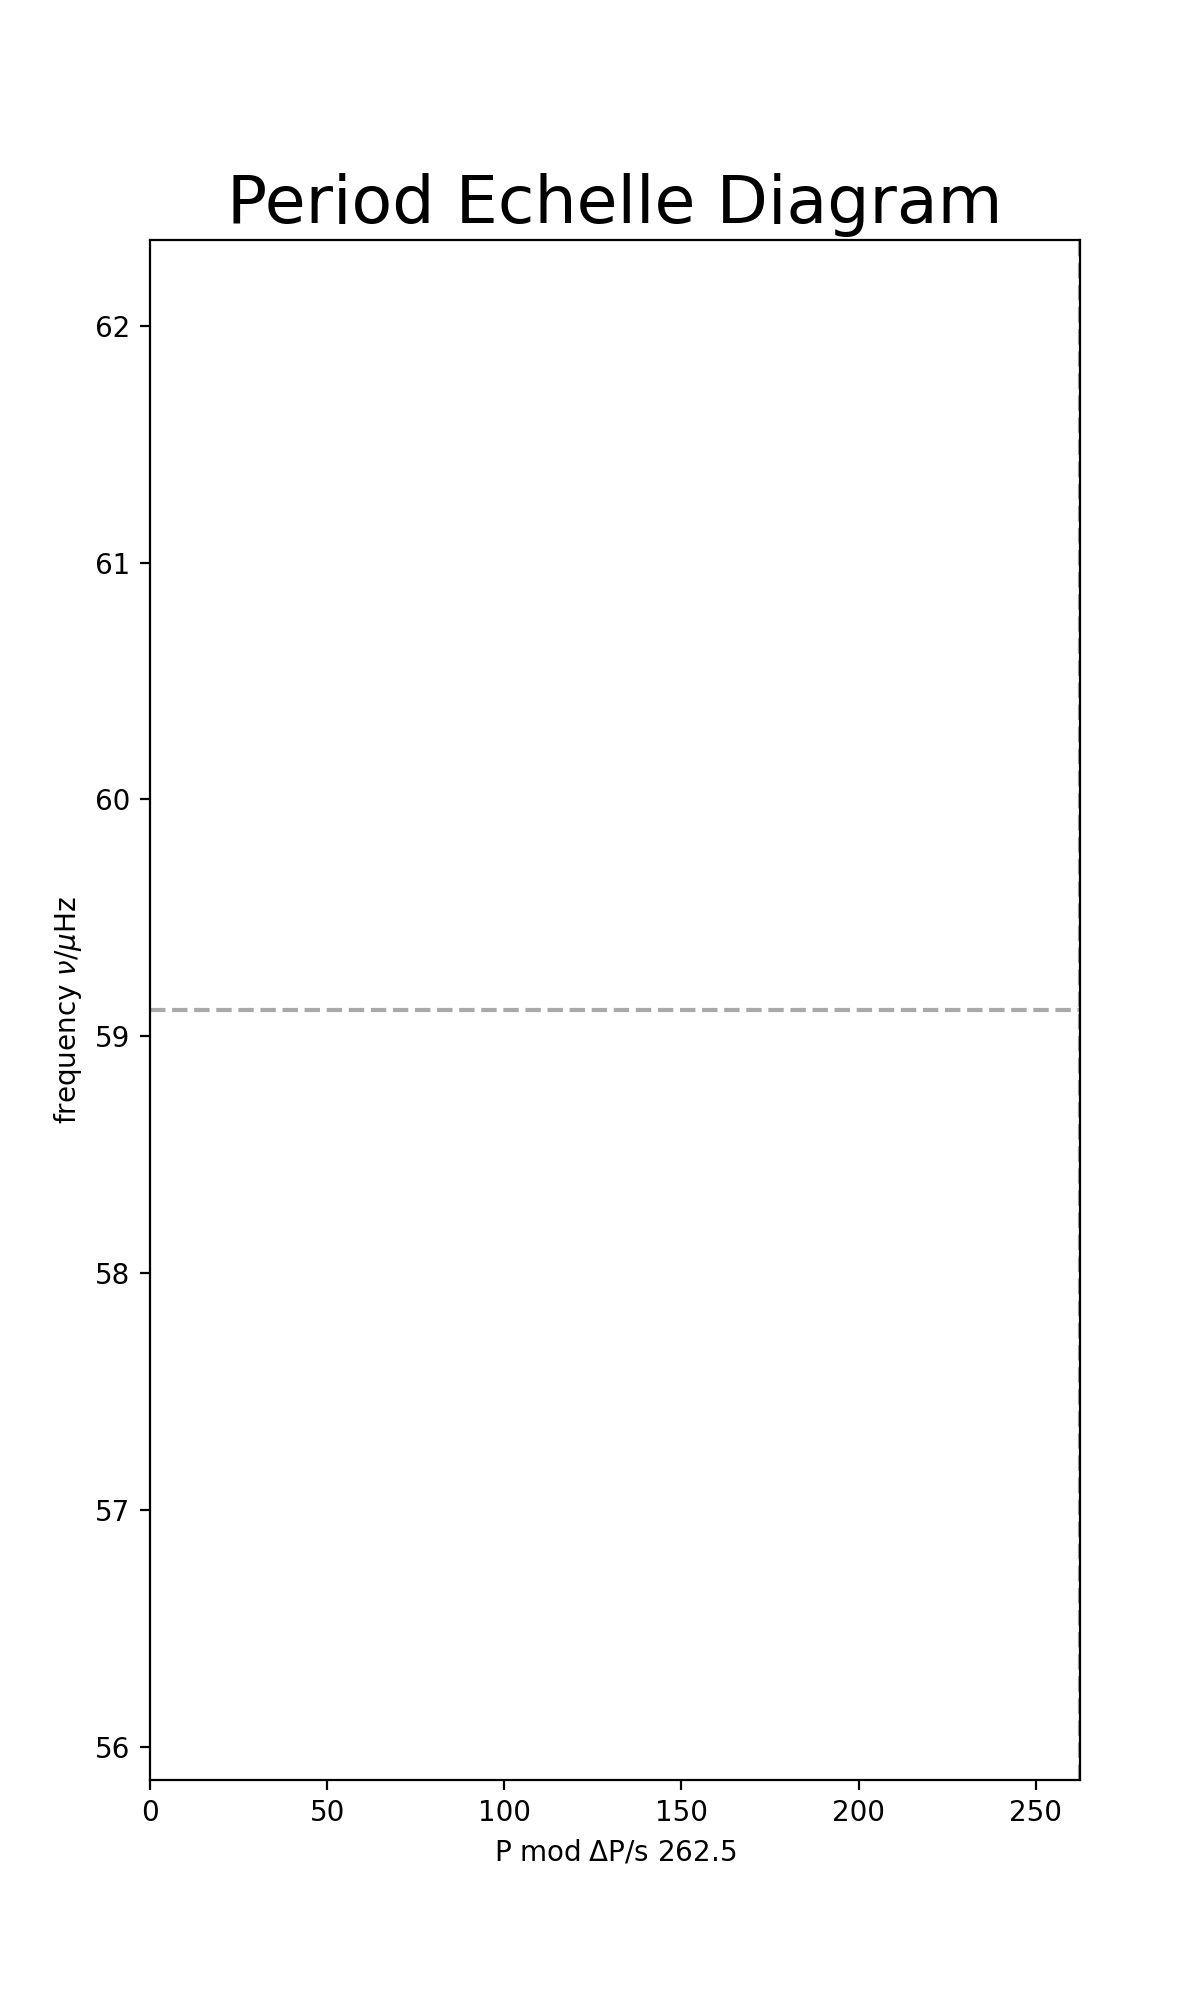

In [14]:
period_echelle(star.f_labels[1],star.numax,star.Dnu,dPi=262.5)